In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pydicom import dcmread, uid
import os
from natsort import natsorted
import nibabel as nib
import pymedphys

tensor(30.2457) tensor(29.8163, dtype=torch.float64)
p0  : 97.45 %
tensor(36.7835) tensor(34.4631, dtype=torch.float64)
l0  : 80.05 %


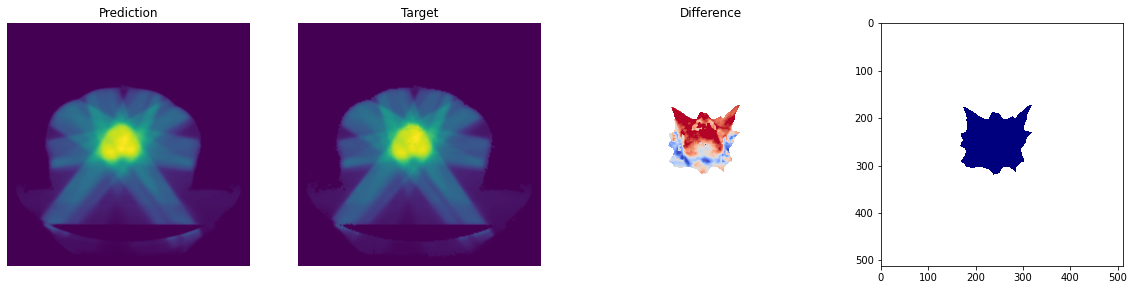

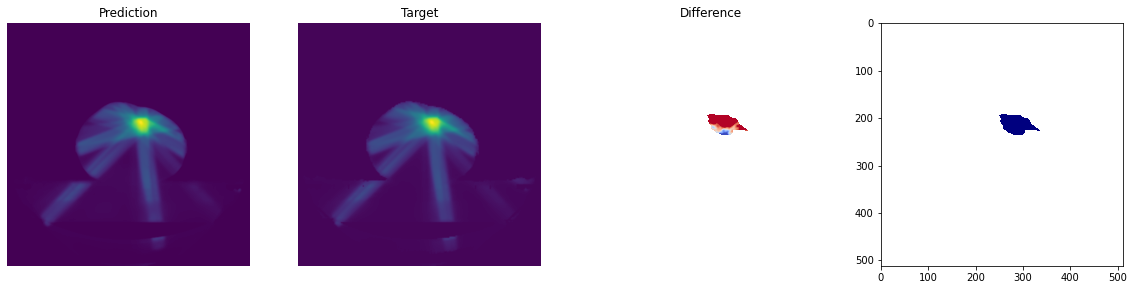

In [3]:
cutoff = 40
thresholds = [3]

for threshold in thresholds:
    gamma_options = {
        'dose_percent_threshold': threshold,
        'distance_mm_threshold': threshold,
        'lower_percent_dose_cutoff': cutoff,
        'interp_fraction': 10,  # Should be 10 or more for more accurate results
        'max_gamma': 1.1,
        'quiet': True,
        'local_gamma': False,
        'random_subset': 2000
    }

    patients = ["p0", "l0"]
    for patient in patients:

        pred = torch.load(f"/Users/simongutwein/Studium/Masterarbeit/plan_predictions/{patient}_prediction.pt")
        target = torch.load(f"/Users/simongutwein/Studium/Masterarbeit/plan_predictions/{patient}_target.pt")
        max_dose = np.where(target == target.max())
        print(target.max(), pred.max())

        diff = target - pred
        diff[target < cutoff/100*target.max()] = np.nan
        diff2 = np.copy(diff)
        diff2[abs(diff2) > np.array(threshold/100*target.max())] = 0
        diff2[abs(diff2) < np.array(threshold/100*target.max())] = 1

        fig, ax = plt.subplots(1,4,figsize=(20,5))
        ax[0].imshow(pred[:, :, max_dose[2]])
        ax[1].imshow(target[:, :, max_dose[2]])
        ax[2].imshow(diff[:, :, max_dose[2]], cmap="coolwarm", vmin=-threshold/100*target.max(), vmax=threshold/100*target.max())
        ax[3].imshow(diff2[:, :, max_dose[2]], cmap="jet")
        ax[0].set_title("Prediction")
        ax[1].set_title("Target")
        ax[2].set_title("Difference")

        for i in range(3):
            ax[i].axis("off")

        # save_path = "/home/baumgartner/sgutwein84/container/test"

        # dat = nib.Nifti1Image(np.array(diff), np.eye(4))
        # dat.header.get_xyzt_units()
        # dat.to_filename(f"{save_path}/{patient}_diff_plan.nii.gz")

        coords = (np.arange(0, 1.1718*target.shape[0], 1.1718), np.arange(
            0, 1.1718*target.shape[1], 1.1718), np.arange(0, 3*target.shape[2], 3))

        gamma_val = pymedphys.gamma(
            coords, np.array(target),
            coords, np.array(pred),
            **gamma_options)

        dat = ~np.isnan(gamma_val)
        dat2 = ~np.isnan(gamma_val[gamma_val <= 1])
        all = np.count_nonzero(dat)
        true = np.count_nonzero(dat2)

        print(patient, " :", np.round((true/all)*100, 2),"%")


In [ ]:
cutoff = 40
thresholds = [3]

for threshold in thresholds:
    gamma_options = {
        'dose_percent_threshold': threshold,
        'distance_mm_threshold': threshold,
        'lower_percent_dose_cutoff': cutoff,
        'interp_fraction': 10,  # Should be 10 or more for more accurate results
        'max_gamma': 1.1,
        'quiet': True,
        'local_gamma': False,
        'random_subset': 2000
    }

    patients = ["p0", "l0"]
    for patient in patients:

        pred = torch.load(f"/Users/simongutwein/Studium/Masterarbeit/plan_predictions/neu/{patient}_prediction.pt")
        target = torch.load(f"/Users/simongutwein/Studium/Masterarbeit/plan_predictions/neu/{patient}_target.pt")
        max_dose = np.where(target == target.max())
        print(target.max(), pred.max())

        diff = target - pred
        diff[target < cutoff/100*target.max()] = np.nan
        diff2 = np.copy(diff)
        diff2[abs(diff2) > np.array(threshold/100*target.max())] = 0
        diff2[abs(diff2) < np.array(threshold/100*target.max())] = 1

        fig, ax = plt.subplots(1, 4, figsize=(20, 5))
        ax[0].imshow(pred[:, :, max_dose[2]])
        ax[1].imshow(target[:, :, max_dose[2]])
        ax[2].imshow(diff[:, :, max_dose[2]], cmap="coolwarm", vmin=-threshold/100*target.max(), vmax=threshold/100*target.max())
        ax[3].imshow(diff2[:, :, max_dose[2]], cmap="jet")
        ax[0].set_title("Prediction")
        ax[1].set_title("Target")
        ax[2].set_title("Difference")

        for i in range(3):
            ax[i].axis("off")

        # save_path = "/home/baumgartner/sgutwein84/container/test"

        # dat = nib.Nifti1Image(np.array(diff), np.eye(4))
        # dat.header.get_xyzt_units()
        # dat.to_filename(f"{save_path}/{patient}_diff_plan.nii.gz")

        coords = (np.arange(0, 1.1718*target.shape[0], 1.1718), np.arange(
            0, 1.1718*target.shape[1], 1.1718), np.arange(0, 3*target.shape[2], 3))

        gamma_val = pymedphys.gamma(
            coords, np.array(target),
            coords, np.array(pred),
            **gamma_options)

        dat = ~np.isnan(gamma_val)
        dat2 = ~np.isnan(gamma_val[gamma_val <= 1])
        all = np.count_nonzero(dat)
        true = np.count_nonzero(dat2)

        print(patient, " :", np.round((true/all)*100, 2), "%")


In [ ]:


# target = torch.load("/Users/simongutwein/Studium/Masterarbeit/test/test/target.pt")
# target = target.squeeze()
# pred = torch.load("/Users/simongutwein/Studium/Masterarbeit/test/test/prediction.pt")
print(target.shape, pred.shape)
print(type(target), type(pred))

max_dose = target.max()
num_split = 25

split_dose = np.linspace(0, max_dose, num_split)
split_dose[-1], target.max()

dices = []
for num, split in enumerate(split_dose):

    temp_target = np.copy(target)
    temp_pred = np.copy(pred)
    temp_target[temp_target < split] = 0
    temp_target[temp_target >= split] = 1

    temp_pred[temp_pred < split] = 0
    temp_pred[temp_pred >= split] = 1

    temp_eval = np.sum(temp_pred * temp_target)

    target_vox = temp_target.sum()
    pred_vox = temp_pred.sum()
    both_vox = temp_eval.sum()

    dices.append((2*both_vox)/(target_vox+pred_vox))

x = np.linspace(0, 100, num_split)
print(x)
print(dices)
plt.plot(x, dices)
plt.show()


In [ ]:
path = "/Users/simongutwein/mnt/qb/baumgartner/sgutwein84/training"


for sub in os.listdir(path):
    missing = False
    sub_dir = os.path.join(path, sub)
    for subsub in os.listdir(sub_dir):
        subsub_path = os.path.join(sub_dir, subsub)
        if os.path.isdir(subsub_path):
            if os.path.isfile(os.path.join(subsub_path, "training_data.pt")):
                continue
            else:
                missing = True
                print(f"Missing data for {subsub}")
    if not missing:
        print(f"No missing data for {sub}")
